## Task 21 - Supervised Learning - Random Forests

In this task we create ensembles of decision trees such as the random forest model that can predict the survival of passengers on the
Titanic.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

# for aggregation
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import permutation_importance

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call, check_call
import pydot, graphviz


from tabulate import tabulate

Import the titanic.csv dataset - note that exploratory data analysis was conducted on this dataset in task 15

In [2]:
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Pre-processing

In [3]:
# We can drop 'PassengerId', 'Name', and 'Ticket' and 'Cabin' as they are not categorial or numerical and not needed for this task, 
# besides 'Cabin' also has too many missing values.
df=df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin' ], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


The .info() shows that some of the 'Age' and 'Embarked' variable data is missing so here we impute these missing values with the median and mode respectively.

In [4]:
df["Age"] = df["Age"].replace(np.NaN, df["Age"].median())
df["Embarked"] = df["Embarked"].replace(np.NaN, df["Embarked"].mode()[0])

Next, we use label encoding for the 'Sex' and 'Embarked' variables, so that the resulting dataframe is fully numeric and suitable for machine learning.

In [5]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df.apply(LabelEncoder().fit_transform)
# Male - 1, Female - 0

df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
df.apply(LabelEncoder().fit_transform)
# Cherbourg - 0, Queenstown - 1, Southampton -2 

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,2,1,28,1,0,18,2
1,1,0,0,51,1,0,207,0
2,1,2,0,34,0,0,41,2
3,1,0,0,47,1,0,189,2
4,0,2,1,47,0,0,43,2
...,...,...,...,...,...,...,...,...
886,0,1,1,35,0,0,85,2
887,1,0,0,24,0,0,153,2
888,0,2,0,36,1,2,131,2
889,1,0,1,34,0,0,153,0


Here we select 'Survived' as the target variable and the remaining varibles form the independent varibles.

In [6]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

feature_names = X.columns

### Test train split

Here we split the data into a training and test sets.

In [7]:
rand = 42

# Split the original dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

### Fitting a decision tree and ensemble models

Here we create a bagged, random forest, and boosted tree for the Titanic data set in
the same way that we created a regular classification tree. We also print out the accuracy score for each model. Note that we will tune the *max_depth* variable later in this notebook

In [8]:
# Create base model
base = DecisionTreeClassifier(max_depth=None, random_state=rand)

# Create ensembles of classifier models: bagged, random forest and boosted
boosted = AdaBoostClassifier(estimator=base, algorithm='SAMME', n_estimators=20, random_state=rand) 
ensemble = BaggingClassifier(estimator=base, n_estimators=20, random_state=rand)
rf = RandomForestClassifier(random_state=rand)

# fit the different classifiers
base.fit(X_train,y_train)
boosted.fit(X_train,y_train)
ensemble.fit(X_train,y_train)
rf.fit(X_train,y_train)

# print out the accuracy of the classifier models
print(f"Accuracy of the base decision tree: {base.score(X_test, y_test)*100:.2f}%")
print(f"Accuracy of the boosted model: {boosted.score(X_test, y_test)*100:.2f}%")
print(f"Accuracy of the bagged model: {ensemble.score(X_test, y_test)*100:.2f}%")
print(f"Accuracy of the random forest model: {rf.score(X_test, y_test)*100:.2f}%")



Accuracy of the base decision tree: 73.54%
Accuracy of the boosted model: 75.78%
Accuracy of the bagged model: 78.03%
Accuracy of the random forest model: 80.27%


### Feature importance

Next we perform a feature importance analysis for the random forest model using the inbuilt sklearn.ensemble method *feature_importances_.* The Gini importance of a feature is related to how much it helps to reduce impurity and to make accurate predictions, that is, a feature with high Gini importance is capable of creating pure splits in the tree and contributes to a cleaner partitioning of the data. The feature that contributes the most to providing purer splits is **Fare**, and this is closely followed by Sex and Age. In addition, and as we discuss next, there is an alternative method for assessing which feature has the most predictive importance.

Text(0, 0.5, 'Features')

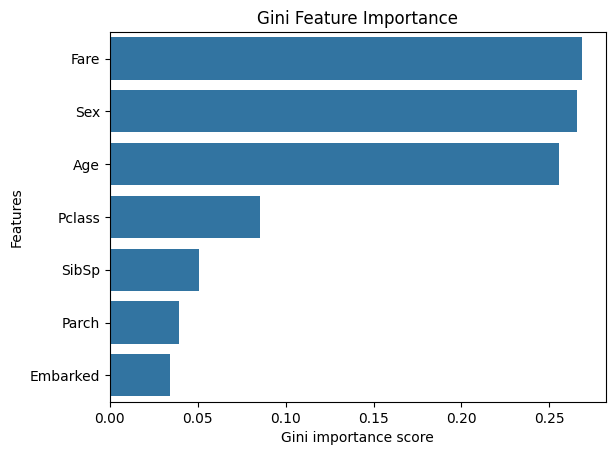

In [9]:
# Finding the important features using the built-in Gini importance
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': rf.feature_importances_}).sort_values('Gini Importance', ascending=False)

# Visualisation of the Gini feature importance
sns.barplot(data=feature_imp_df, x=feature_imp_df['Gini Importance'],y=feature_imp_df['Feature'])
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")

The permutation importance which assesses how a feature affects the model’s predictive performance on the *test* data. To do this we randomly shuffle the values of a single feature and then measure the reduction in model accuracy. The greater the reduction is, the more permutation importance the feature has. Using this measure **Sex** is the variable that contributes the most to predicting whether a passenger survives or not.

Text(0, 0.5, 'Features')

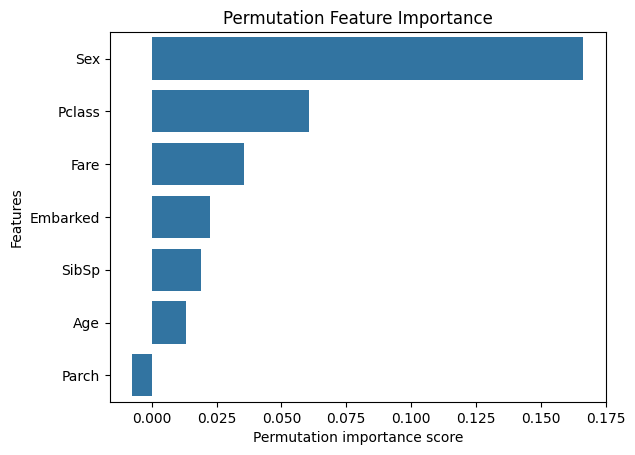

In [10]:
# Finding the permutation importance of features using the built-in permutation_importance
perm_imp = permutation_importance(rf, X_test, y_test, n_repeats=100, random_state=rand, n_jobs=-1)
perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': perm_imp.importances_mean}).sort_values('Permutation Importance', ascending=False)

# Visualisation of the permutation feature importance
sns.barplot(x=perm_imp_df['Permutation Importance'],y=perm_imp_df['Feature'],data=perm_imp_df)
plt.title("Permutation Feature Importance")
plt.xlabel("Permutation importance score")
plt.ylabel("Features")

### Hyperparameter tuning

Next we will tune the parameters n_estimators and max_depth for the random forest model. The output shows that the best random forest model has parameters *max_depth*=7 and *n_estimators*=90

In [11]:
# Hyperparameter tuning for Random Forest using GridSearchCV and fit the data.
# Note that I have iteratively used the params grid, using a coarser grid to begin with before 'fine-tuning'

params = {
    'max_depth': [4,5,6,7,8,9,10,15,20],
    'n_estimators': [50,80,90,100,110,120,200,250,500]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,                   # cross-validation parameter
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
{'max_depth': 7, 'n_estimators': 90}


### Comparing models

Here we provide a report on the accuracy of all models.

The random forest model with parameters of *max_depth*=7 and *n_estimators*=90 was the best performing model.

In [12]:
best_depth = grid_search.best_params_['max_depth']
best_estimators = grid_search.best_params_['n_estimators']

names = [
    "Decision Tree",
    "Boosted",
    "Bagged",
    "Random Forest",
    "Random Forest with tuning",
]

classifiers = [
    DecisionTreeClassifier(max_depth=None,random_state=rand),
    AdaBoostClassifier(estimator=base, algorithm='SAMME', n_estimators=20, random_state=rand),
    BaggingClassifier(estimator=DecisionTreeClassifier(random_state=rand), n_estimators=20, random_state=rand),
    RandomForestClassifier(random_state=rand),
    RandomForestClassifier(max_depth=best_depth, n_estimators=best_estimators, random_state=rand)
]

In [13]:
#Iterating over all the classifiers
data = []
for name, clf in zip(names, classifiers):
  clf.fit(X_train, y_train)
  accuracy = round(clf.score(X_test, y_test)*100,2)
  data.append([name, accuracy])

print(tabulate(data, headers=["Model", "Accuracy (%)"], tablefmt='fancy_outline', colalign=("center",)))
print(f"The Random Forest model tuned with a max depth of {best_depth} and {best_estimators} estimators had the highest accuracy of {data[4][1]}%")

╒═══════════════════════════╤════════════════╕
│           Model           │   Accuracy (%) │
╞═══════════════════════════╪════════════════╡
│       Decision Tree       │          73.54 │
│          Boosted          │          75.78 │
│          Bagged           │          78.03 │
│       Random Forest       │          80.27 │
│ Random Forest with tuning │          81.61 │
╘═══════════════════════════╧════════════════╛
The Random Forest model tuned with a max depth of 7 and 90 estimators had the highest accuracy of 81.61%
